## Homework 3 - Single Cell Clusters to Cell Types
This homework contains 11 questions, worth a total of 100 points. There are a mixture of questions to answer and code blocks to fill in. For written, open-ended questions, please answer as briefly as possible (e.g. 1-3 sentences).

You will be writing your own cluster analysis method for use in interpreting single cell RNA sequencing data and observing how well it recapitulates known cell types.

Execute the initial code blocks below to set up the necessary Python libraries.

In [1]:
!pip install scanpy
!apt-get install -y libigraph0-dev
!pip install igraph-python
!pip install python_louvain
!pip install gseapy

     |████████████████████████████████| 7.2MB 2.2MB/s 
     |████████████████████████████████| 122kB 29.0MB/s 
     |████████████████████████████████| 51kB 7.5MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libamd2 libcolamd2 libglpk40 libigraph0v5 libsuitesparseconfig5
Suggested packages:
  libiodbc2-dev default-libmysqlclient-dev
The following NEW packages will be installed:
  libamd2 libcolamd2 libglpk40 libigraph0-dev libigraph0v5
  libsuitesparseconfig5
0 upgraded, 6 newly installed, 0 to remove and 31 not upgraded.
Need to get 1,286 kB of archives.
After this operation, 4,103 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libsuitesparseconfig5 amd64 1:5.1.2-2 [9,044 B]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libamd2 amd64 1:5.1.2-2 [19.5 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 libcola

###***Basic concepts***
In this homework, you will be asked to implement your own K-means clustering algorithm. $K$-means clustering belongs in the family of algorithms called unsupervised machine-learning. In this setting, the goal is to identify grouping patterns in the data and partition the observations into distinct clusters. Data points in the same cluster share some properties. Clusters provide a high level understanding of data to help summarize into a categorization.

Each cluster can be associated with a centroid that describes the average pattern of its members across the data features defined as:

\begin{align}
\mu_i = \frac{1}{\mid{C_i}\mid} \displaystyle\sum_{x \epsilon C_i}{x},
\end{align}

where $\mid{C_i}\mid$ denotes the number of samples in cluster $C_i$, and $x$ is a point drawn from the $i^{th}$ cluster $C_i$.

The algorithm  iteratively assigns data points to one of $K$ groups based on the features that are provided. Data points are clustered based on feature similarity or distance. In this homework, we use the Euclidean distance to measure the similarity between two samples, say $x_1$ and $x_2$:

\begin{align}
D(x_1,x_2) = \sqrt{\sum_{i=1}^{F}{(x_{1i}-x_{2i})^2}},
\end{align}

where $F$ is the total number of features for the samples. Note that the samples are in the rows and the features are in the columns.
In this homework, the features are genes since the data provided are gene expression levels for each sample. The results of the $K$-means clustering algorithm will be:

*   A set of centroids, one for each of the $K$ clusters.
*   A cluster label for each data point sample.

---
## $\textbf{The Algorithm}$

Assume you have data point $ x_1, x_2, x_3, ..., x_n, n \epsilon \mathbb{R}^F$, where $F$ denotes the number of features (genes) describing each data point. $K$-means proceeds using the following steps:

1. Pick $K$ data-points at random to represent the initial cluster centroids from the data set. Note that a seed has been selected for you, so that the same data-points are selected every time you re-run the method 

2. Find the Euclidean distance of each point in the data set with each of the $K$ centroids.

3. Assign each data point to the cluster that has the closest centroid using the distance function above. I.e. each data point $x$ is assigned to a cluster based on:

\begin{align}
L(x)=argmin_{i=1...K} D(\mu_i,x).
\end{align}

* Hint: For your code, $D(\mu_i,x)$ is equivalent to the norm between two vectors; i.e. $D(\mu_i,x)^2 =  \|\mu_i-x\|$.

4. Find the new centroid by taking the average of the sample points (columns) in each cluster group.
5. Repeat steps 2 to 4 for a fixed number of iterations ($\textbf{max_iter}=300$) or until none of the centroids have changed. To quantify the change in a particular centroid $\mu_i$, calculate the change in each feature $j$ of the centroid and sum over all features:

\begin{align}
\Delta_i = \sum_{j=1}^{F}{\frac{\mid \mu'_{ij}-\mu_{ij}\mid}{\mu'_{ij}}},
\end{align}

* where $\mu'_i$ represents the centroid in the previous iteration. This quantifies a percent change between the previous and current centroids. If every centroid is within a tolerance threshold, say $\textbf{tol}=0.001$, then declare convergence and stop iterating. If the threshold is never met, iteration will stop when max_iter iterations have been executed.
---

**Environment Setup**

1. Download all files under HW3 folder in your local environment
2. Change directory in the below code block as follows:
```
import os
os.chdir('my/local/dir/')
```
3. Should you choose to work from Gooogle Colab do the following:
    * Copy the HW3 folder in your drive
    * Excecute the lines below:
```
from google.colab import drive
drive.mount('/content/drive')
```
* Then the `.chdir` command should look like:
```
os.chdir('drive/My Drive/HW3/')
```

###Question 1 (20pts). Write the Kmeans class in the code block below.



In [2]:
import scanpy as sc
from google.colab import drive
drive.mount('/content/drive')
import os

# this command for my personal folder
# os.chdir('drive/My Drive/BME230B/Homework_3/')

# this command for the standard colab notebook path
os.chdir('drive/My Drive/HW3/')
import gseapy as gp
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import gmean
from sklearn.metrics import adjusted_rand_score
import scipy
from collections import OrderedDict

np.random.seed(42)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Creating directory /root/.config/bioservices 


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
class K_Means:
    def __init__(self, k=2, tol=0.001, max_iter=300):
        self.k = k
        self.tol = tol
        self.max_iter = max_iter

    def fit(self,data):
        # empty adata object every time method is run
        self.adata = data # adata object
        if 'cluster' in self.adata.obs.columns:
            self.adata.obs = self.adata.obs.drop(columns='cluster')
        data = data.obsm['X_pca']

        # fill in code with steps 1-5 described above
        # make sure to use update_adata method to update the annotations withing the adata object

        # Pick  K  data-points at random to represent the initial cluster centroids from the data set. 
        # Note that a seed has been selected for you, so that the same data-points are selected every time 
        # you re-run the method
        samples = [_ for _ in range(self.adata.X.shape[0])]
        k_points = np.random.choice(samples, size=self.k, replace=True, )
        k_centers = np.array([data[i, :] for i in k_points])

        for iter_ in range(self.max_iter):

            # Find the Euclidean distance of each point in the data set with each of the  K  centroids
            D_matrix = self.get_distance_matrix(data, k_centers)

            # Assign each data point to the cluster that has the closest centroid using the distance function above. 
            # I.e. each data point  x  is assigned to a cluster based on:
            # L(x) = np.argmin(D(center_i, x))
            cluster = np.array([np.argmin(D_matrix[j, :]) + 1 for j in range(D_matrix.shape[0])])
        
            # Find the new centroid by taking the average of the sample points (columns) in each cluster group
            classification = [np.array([data[index] for index in range(len(cluster)) if cluster[index] == i + 1 ]) for i in range(self.k)]
            k_centers_new = self.get_new_centroids(classification)

            # now check if they have converged. 
            thresholds = np.array([1/len(classification[clust_]) * (sum(k_centers_new[clust_] - k_centers[clust_])/sum(k_centers_new[clust_])) for clust_ in range(self.k)])
            k_centers = k_centers_new
            if thresholds.max() <= self.tol: break
            

        # now update the adata
        idx_values = np.array([[index for index in range(len(cluster)) \
                                         if cluster[index] == i + 1 ] for i in range(self.k)])
        self.classifications = np.array([(i, idx_values[i]) for i in range(len(idx_values))])
        self.update_adata()

    def get_distance_matrix(self, data, k_centers):
        # gets the elucidian distance matrix.
        D_matrix = []
        for x_1 in range(data.shape[0]):
            col = []
            for centroid in range(k_centers.shape[0]):
                col.append(np.sqrt(np.sum((data[x_1, :] - k_centers[centroid, :])**2)))
            D_matrix.append(col)
        return np.array(D_matrix)

    def get_new_centroids(self, classification):
        # gets the new k_centers matrix.
        center_matrix = []
        for group in classification: center_matrix.append(group.mean(axis=0))
        return np.array(center_matrix)
        
    def update_adata(self):
        # updates the adata object.
        self.adata.obs['cluster'] = self.adata.obs.shape[0]*[np.nan]
        for classification, idx_values in self.classifications:
            samples = self.adata.obs.iloc[idx_values].index
            
            self.adata.obs.loc[samples, 'cluster'] = classification
        self.adata.obs.cluster = self.adata.obs.cluster.astype('category')


## PBMC data
Lets now use your clustering method to cluster a  dataset that measured the gene expression levels of individual cells collected from  circulating blood in which periphal blood mononuclear cells (PBMCs) were enriched. This dataset was published by 10X genomics to demonstrate the capabilities of their single cell sequencing platforms.

* We have made a copy of this dataset for you to download in the [PBMC H5 File](https://drive.google.com/open?id=19QBoKgPNEOw8VNvpcH7VMJ63RvMsw989). You should download this to your own directory and name the file PBMC_hw3.h5ad.

The dataset contains quantified gene expression data in the form of log(CPM+1) where CPM stands for counts-per-million mapped reads. CPM is a popular quantification of gene expression that normalizes for the sequencing depth of the assay so that the expression levels can be (theoretically) compared across experiments.

Note that the dataset has already been clustered with the Louvain algorithm. You will compare the solution against your own in a later part of the homework. The Louvain solution produced 22 clusters.

In [4]:
adata = sc.read('PBMC_hw3.h5ad')

/usr/local/lib/python3.6/dist-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


## Perform K-Means clustering using your K-Means class
* Run your kmeans algorithm using the same number of cell types known to be measured in the dataset (k=6).
* Your code should update the adata object to update the cluster assignments under the cluster adata field.

In [0]:
#fill in code 
k_clust = K_Means(k=6)
k_clust.fit(adata)

## Question 2 (5 pts). Make a UMAP plot annotated with the cluster assignments determined by you K-Means class.
## Question 3 (5 pts). Make a UMAP plot annotated with the cell type assignment 

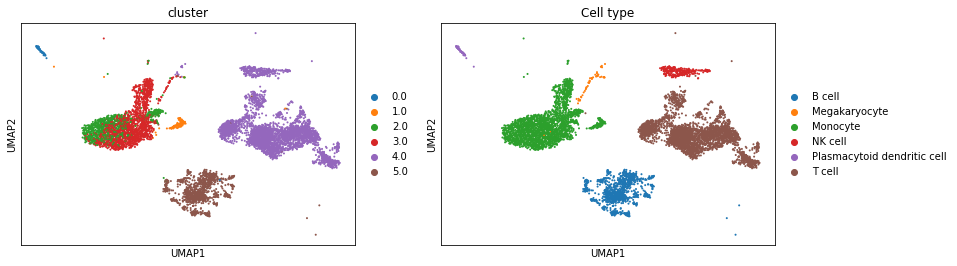

In [6]:
# fill in code
sc.pl.umap(adata, color=['cluster', 'Cell type'])

## Question 4 (5 pts). In a couple of sentences, describe the correspondance between your clusters and the annotated cell types. Are all cell types captured well by your clusters? Are some overly clustered? Are some merged?
**The clusters I made did capture some clusters well like the dendritic and B-cells. However for example the 4.0 cluster overly captures more than one group of cell types which are the T-cell and NK cells. The 2.0 also under captures the monocyte cell group - which then is over captured by cluster 3.0 which has both the megakarayocte and the monocyte group.**

Rather than subjectively describing the association between known cell types and the clustering result, your next task is to objectively quantify this relationship. The Adjusted Rand Index (ARI) measures the agreement between two partitionings (e.g. clusters or cell type annotations) of the data. For every pair of samples, the ARI calculates a score based on the number of sample pairs that are either a) clustered together in both paritionings, or b) not clustered together in both, or c) clustered together in only one of the partitionings and not the other. The first two types of sample pairs measure the agreement, while the last measures the disagreement, between the partitionings. Use the ARI to measure how well $K$-means solutions of different $K$ correspond to the known cell types. Use it to choose the best $K$.

**Optimize K-Means clustering**
* Test $k$ from 5 clusters up to the number produced by Louvain ($k$=22).
* For each $k$, calculate ARI. Call the ARI function on the adata object to obtain how well the clusters fit the known cell types
* Also calculate ARI for the Louvain clustering solution.

## Question 5 (10 pts). Plot the ARI for each k, and for Louvain


In [0]:
# fill in code
ARI = []
for k in range(5, 23):
    k_clust = K_Means(k=k)
    k_clust.fit(adata)
    ARI.append(adjusted_rand_score(adata.obs['Cell type'], adata.obs['cluster']))

louvian_ARI = adjusted_rand_score(adata.obs['Cell type'], adata.obs['louvain'])

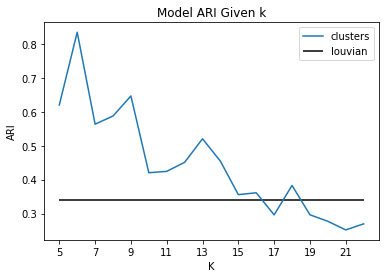

In [8]:
# fill in code
plt.plot([k for k in range(5, 23)], ARI)
plt.xticks([i for i in range(5, 23, 2)])
plt.hlines(louvian_ARI, 5, 22)
plt.title('Model ARI Given k')
plt.ylabel('ARI')
plt.xlabel('K')
plt.legend(['clusters', 'louvian'])
plt.show()

## Question 6 (5 pts). What value of $K$ seems to best achieve a correspondance between the cell types and the clusters and is this better than the Louvain solution?
**Based on the plot above, a $K$ of $6$ appears to be the best option for cell type and cluster corrispondence, and was significantly better than the louvian solution.**

Now that you have found a good $K$, lets again take a look at the data.

## Question 7 (15 pts). Re-run your K-Means class with the best $k$ you found using the ARI score and re-plot UMAP with cluster annotations for that $k$. Plot a UMAP for the cell type assignments, for your cluster assignments with the best $k$ and for the Louvain assignments (i.e. make 3 different UMAP plots below).

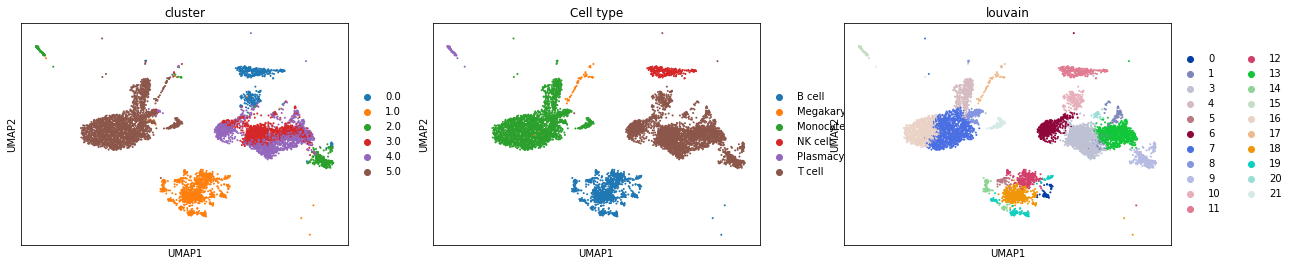

In [9]:
# fill in code
k_clust = K_Means(k=6)
k_clust.fit(adata)
sc.pl.umap(adata=adata, color=['cluster', 'Cell type', 'louvain'])

Biologists use "marker genes" to identify or sort known cell types from other cell populations. We would now like to determine if any marker sets distinguish the clusters. By comparing the samples in a cluster to those outside of a cluster, we can determine the genes that have expression distinct for the samples inside versus outside of the cluster. From this ensemble of genes, we'd like to know if marker genes of a known cell type are among the top distinctly expressed genes.

A first step to do this is to score each gene for how distinct its expression is in a particular cluster compared to others. We will use the Wilcoxon method to measure this for each cluster and each gene. The Wilcoxon test is nonparametric: it replaces the expression levels with a global ranking across all of the samples and then determines if the sum of the ranks is higher than expected by chance within a sample set of interest (e.g. a cluster). Let the Wilcoxon differential score for gene feature $f$ for cluster $i$ be $W_{if}$. Thus, $W_{if}$ measures the extent to which gene $f$ has higher (or lower) expression in samples of cluster $i$ compared to clusters outside of $i$. Your next task is to compute the $W$ matrix and then we will perform enrichment analysis on each of the rows (clusters) of $W$.

## Question 8 (15 pts). Fill in the code block below to perform differential gene expression analysis on your clusters.
1. Use the wilcoxon method within scanpy's scanpy.tl.rank_gene_groups method.
2. Use the Bonferroni correction method.
3. Perform the analysis for each cluster against all other clusters (one-vs.-all comparison). You will get differential scores for each cluster (against all other clusters).
4. Plot the top 20 most differentially expressed genes for each cluster using scanpy.pl.rank_genes_groups method.

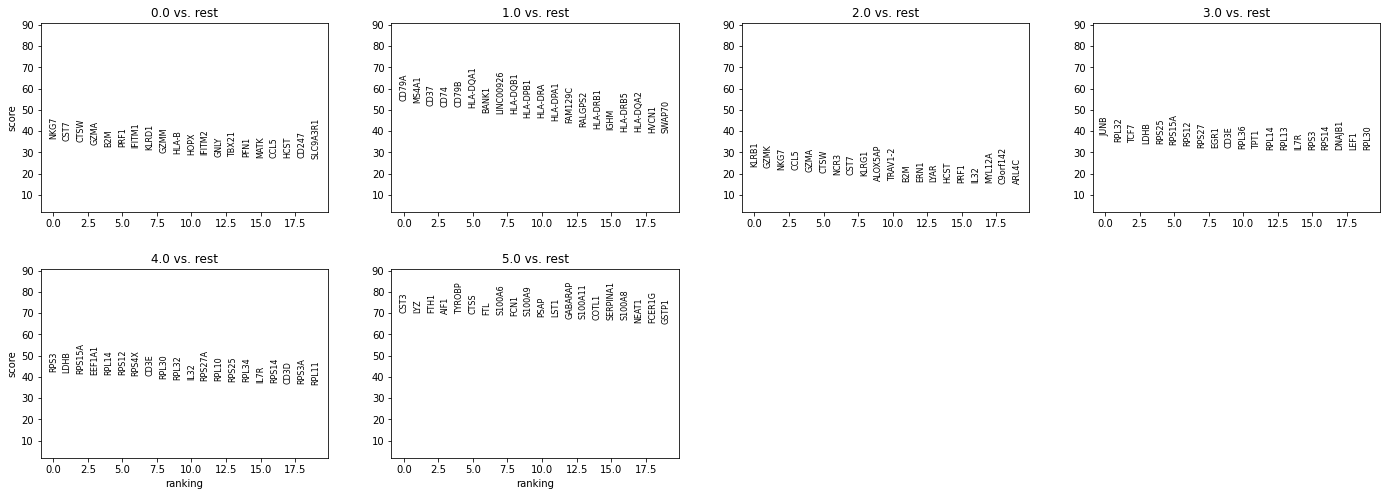

In [10]:
# fill in code
sc.tl.rank_genes_groups(adata, method='wilcoxon', corr_method='bonferroni', groupby='cluster', n_genes = adata.var.shape[0])
sc.pl.rank_genes_groups(adata, n_genes=20)

You should next determine if the top-scoring genes for each cluster have an overrepresentation of any known marker genes.

# Question 9 (10 pts).  Perform marker enrichment analysis using GSEA:
* Download the provided GMT file [immune_cell_marker_genes_manual_19-08-30.gmt](https://drive.google.com/file/d/1Tkx6_3gjB-bS3prOS5eNX7A5Xmm_QrsG/view?usp=sharing) that contains the marker gene sets. A GMT file is a gene-matrix-transposed file that contains, on each line, a tab-delimited list of gene members for a particular set. The first item on the line is the set identifier, in this case, the name of the cell type. The rest of the line contains gene names written using the HUGO official symbol for the gene.
* Pass that file in the geneset argument of gseapy
* Hint: enrichment analysis should be done on a per-cluster basis
* Report the cell type for each cluster that produces the lowest p-values. Make a table containing the cluster, cell type, and p-value for the assignment.



In [0]:
# fill in code
name_columns = np.array([list(item) for item in adata.uns.data['rank_genes_groups']['names']])
scores = np.array([list(item) for item in adata.uns.data['rank_genes_groups']['scores']])

In [12]:
final_results = []
for i in range(name_columns.shape[1]):
    df = pd.DataFrame(data = {0: name_columns[:, i], 1: scores[:, i]})
    results = gp.prerank(rnk=df, gene_sets='immune_cell_marker_genes_manual_19-08-30.gmt', min_size= 1)
    final_results.append(results.res2d.sort_values('pval', ascending=True).head(1))

for i in range(name_columns.shape[1]):
    final_results[i]['cluster'] = i
final_frame = pd.concat(final_results, axis=0)

final_frame.head(name_columns.shape[1])

,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes,cluster
Term,,,,,,,,,
T-Cells CD3D CD3D,0.675925,1.813429,0.206997,0.370954,6,3,CD8A;CD2;CD8B,CD8A;CD2,0
B-Cells HLA-DRB1 HLA-DRB1,0.964854,2.537332,0.000000,0.000000,4,4,MS4A1;IGHM;CD19;CD40,MS4A1;IGHM;CD19;CD40,1
T-Cells CD3D CD3D,0.711019,1.975314,0.074896,0.084637,6,4,CD8A;CD2;CD3G;CD8B,CD8A;CD2;CD3G,2
T-Cells CD3D CD3D,0.873746,2.085067,0.009790,0.009790,6,3,CD3G;CD5;CD2,CD3G;CD5;CD2,3
T-Cells CD3D CD3D,0.745394,1.756768,0.071608,0.071608,6,5,CD3G;CD5;CD2;CD8B;CD8A,CD3G;CD5;CD2;CD8B;CD8A,4
Monocytes HLA-DRB1 HLA-DRB1,0.949917,2.439709,0.104651,0.324056,1,1,CD14,CD14,5


# Question 10 (5 pts) The adjusted p-values may have been overcorrected in the sense that some clusters have no significant cell type assignments (e.g. no p-values smaller than say 0.05). Argue whether you believe you have found the correct cell types for the clusters anyway (e.g. comparing qualitative plots). If you believe you have indeed found the correct assignments, how might the multitest correction be changed?

**I do not believe we found the correct cell types for the all clusters - the only ones for sure verified by the numbers is T-cell and B-cell clusters. However based on the qualitative plots the monocytes value matches despite the not so ideal p value score.**



## Question 11 (5 pts). If we were concerned about the different sizes of the clusters influencing the calculation of the differential gene expression scores, how might we correct for it?

**This is more of a hunch - but for example in the polynomial version of Linear Regression - there is the regularization constant - which gives penalty for elements in the model that are in a higher degree than the rest of the model. We could do a similar idea where we could like normalize the size of the clusters so that cell types in significantly smaller clusters could be accounted for in a slightly easier manner.**

